In [1]:
import numpy as np

In [2]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
%matplotlib inline
mp.rcParams['figure.figsize'] = (12, 8)

# DR1 QSO data
VLBI sources

In [3]:
from astroquery.gaia import gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [4]:
tables = gaia.load_tables()

Retrieving tables...
Parsing tables...
Done.


In [5]:
t = tables[0]

In [6]:
t.get_name()

'public.dual'

In [7]:
for t in tables :
    print(t.get_name())

public.dual
public.igsl_source
public.tycho2
public.hipparcos
public.hipparcos_newreduction
public.hubble_sc
public.igsl_source_catalog_ids
tap_schema.tables
tap_schema.columns
tap_schema.keys
tap_schema.schemas
tap_schema.key_columns
gaiadr1.phot_variable_time_series_gfov
gaiadr1.ppmxl_neighbourhood
gaiadr1.gsc23_neighbourhood
gaiadr1.ppmxl_best_neighbour
gaiadr1.sdss_dr9_neighbourhood
gaiadr1.rrlyrae
gaiadr1.allwise_neighbourhood
gaiadr1.gsc23_original_valid
gaiadr1.tmass_original_valid
gaiadr1.allwise_best_neighbour
gaiadr1.cepheid
gaiadr1.urat1_neighbourhood
gaiadr1.ppmxl_original_valid
gaiadr1.tmass_neighbourhood
gaiadr1.ucac4_best_neighbour
gaiadr1.ucac4_neighbourhood
gaiadr1.aux_qso_icrf2_match
gaiadr1.phot_variable_time_series_gfov_statistical_parameters
gaiadr1.sdssdr9_original_valid
gaiadr1.urat1_best_neighbour
gaiadr1.variable_summary
gaiadr1.ucac4_original_valid
gaiadr1.tmass_best_neighbour
gaiadr1.gsc23_best_neighbour
gaiadr1.gaia_source
gaiadr1.ext_phot_zero_point
gaiadr1

In [8]:
r = gaia.launch_job("SELECT TOP 10000 * FROM gaiadr1.aux_qso_icrf2_match").get_data()

Launched query: 'SELECT TOP 10000 * FROM gaiadr1.aux_qso_icrf2_match'
Retrieving sync. results...


Query finished.


In [9]:
r[:10]

solution_id,source_id,ref_epoch,ra,ra_error,dec,dec_error,ra_dec_corr,phot_g_mean_mag,astrometric_priors_used,icrf2_match,rot_flag
,,Time[Julian Years],Angle[deg],Angle[mas],Angle[deg],Angle[mas],Dimensionless[see description],Magnitude[mag],,,
int64,int64,float64,float64,float64,float64,float64,float32,float64,int32,object,int32
2887471466167664679,2314315845817748992,2015.0,0.084997834509302123,0.32454496110414766,-32.350342922055113,0.23511271706447415,-0.070142001,17.960360811574983,6,J000020.3-322101,0
2887471466167664679,2415835438037302144,2015.0,0.27220319345271554,0.48447433249942484,-15.851965471662275,0.289038978259334,0.29972801,18.211357621205455,6,J000105.3-155107,0
2887471466167664679,2340552083046197504,2015.0,0.54992254701623544,1.393162337531358,-21.886073473713015,0.7727802006932547,0.46471101,19.075756315822794,6,J000211.9-215309,0
2887471466167664679,2365814049884978048,2015.0,0.81645557565033022,0.47688597298409802,-19.697333468550926,0.27210861258362623,0.389137,18.972714358778635,6,J000315.9-194150,0
2887471466167664679,2365855384650325376,2015.0,0.82781223795806547,0.59122181302439014,-19.456210016180261,0.35932905596162351,0.15206601,19.246310278493571,6,J000318.6-192722,0
2887471466167664679,2421598528234887680,2015.0,1.0204793193290835,0.39511285389689393,-11.816218502798884,0.30157778045863964,0.81981897,19.235530354602556,6,J000404.9-114858,0
2887471466167664679,4978016560925910400,2015.0,1.1485647503252263,0.55844130817853166,-47.605445547523409,0.78568119733353048,-0.435837,19.853552601975245,6,J000435.6-473619,3
2887471466167664679,420305499589122944,2015.0,1.268180970761839,0.51854447058139552,54.473590020485418,0.82875538402414695,-0.201741,18.581214684739777,6,J000504.3+542824,0


In [10]:
columns = ['ra','ra_error','dec','dec_error','ra_dec_corr','phot_g_mean_mag']

I like pandas

In [11]:
d = r.to_pandas()[columns]

In [12]:
d[:10].round(3)

,ra,ra_error,dec,dec_error,ra_dec_corr,phot_g_mean_mag
0,0.085,0.325,-32.350,0.235,-0.070,17.960
1,0.272,0.484,-15.852,0.289,0.300,18.211
2,0.550,1.393,-21.886,0.773,0.465,19.076
3,0.816,0.477,-19.697,0.272,0.389,18.973
4,0.828,0.591,-19.456,0.359,0.152,19.246
5,1.020,0.395,-11.816,0.302,0.820,19.236
6,1.149,0.558,-47.605,0.786,-0.436,19.854
7,1.268,0.519,54.474,0.829,-0.202,18.581
8,1.325,0.339,-16.801,0.188,0.426,17.722
9,1.334,0.242,5.403,0.157,0.764,16.070


Correlation

$$ M=
  \begin{bmatrix}
    ra_{error} & dec_{error} \\
  \end{bmatrix} 
  \begin{bmatrix}
    1 & corr \\
    coor & 1 \\
  \end{bmatrix} 
  \begin{bmatrix}
    ra_{error} \\
    dec_{error} \\
  \end{bmatrix}  $$

$$\sigma^2 = \frac{ra_{error}^2 + dec_{error}^2 + \sqrt{(ra_{error} − dec_{error})^2 + (2  ra_{error} dec_{error}  corr)^2}}{2}$$

In [13]:
def pos_sigma(ea,ed,c) : 
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

In [14]:
d['sigma'] = pos_sigma(d.ra_error,d.dec_error,d.ra_dec_corr)

In [15]:
def DR1error(g): 
    if g <= 15 :
        return 0.05 
    return 0.05*np.exp(0.2*(g-15)*(g-15))

DR1error = np.vectorize(DR1error)

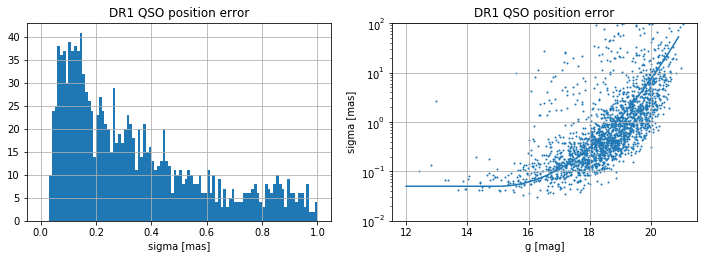

In [16]:
plt.subplot(221)
d.sigma.hist(bins=100,range=(0,1))
plt.xlabel("sigma [mas]")
plt.title("DR1 QSO position error")
plt.subplot(222)
plt.scatter(d.phot_g_mean_mag,d.sigma,s=1)
plt.yscale('log')
plt.ylim(1e-2,100)
g = np.arange(12,21,0.1) 
plt.plot(g,DR1error(g))
plt.grid()
plt.xlabel("g [mag]")
plt.ylabel("sigma [mas]")
plt.title("DR1 QSO position error")

# DR2 errors

from https://www.cosmos.esa.int/web/gaia/dr2

The five-parameter astrometric solution :
- positions on the sky (α, δ), parallaxes, and proper motions 
- for more than 1.3 billion (1e9) sources, with a limiting magnitude of G = 21 and a bright limit of G ≈ 3. 
- Parallax uncertainties are in the range of up to 0.04 milliarcsecond for sources at G < 15, around 0.1 mas for sources with G=17 and at the faint end, the uncertainty is of the order of 0.7 mas at G = 20. 
- The corresponding uncertainties in the respective proper motion components are up to 0.06 mas yr-1 (for G < 15 mag), 0.2 mas yr-1 (for G = 17 mag) and 1.2 mas yr-1 (for G = 20 mag). 

An additional set of more than 200 million sources for which a two-parameter solution is available:
- the positions on the sky (α, δ) combined with the mean G magnitude, with a limiting magnitude of G ≈ 21 and a bright limit of G ≈ 3. 
- These sources will have a positional uncertainty at G=20 of about 2 mas, at J2015.5.

The Gaia DR2 parallaxes and proper motions are based only on Gaia data; they do no longer depend on the Tycho-2 Catalogue.

In [17]:
def pm_error_DR2(g): 
    if g <= 15 :
        return 0.06
    return 0.06*np.exp(0.6*(g-15))

pm_error_DR2 = np.vectorize(pm_error_DR2)

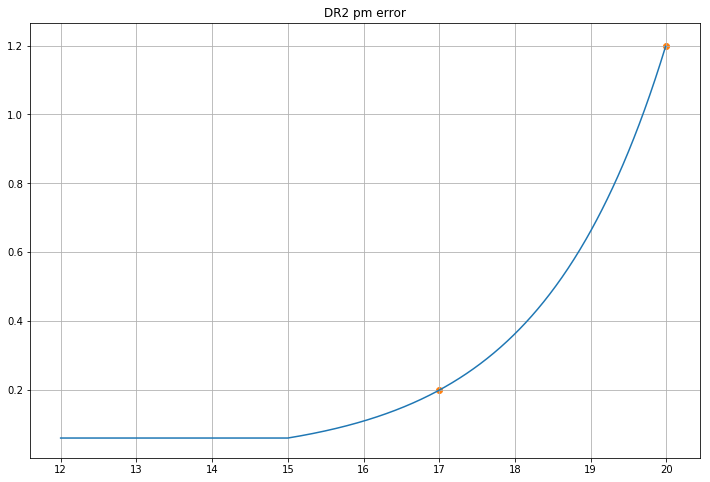

In [18]:
g = np.arange(12,20,0.01) 
plt.plot(g,pm_error_DR2(g))
plt.scatter(17,0.2,c='C1')
plt.scatter(20,1.2,c='C1')
plt.grid()
plt.title("DR2 pm error")

In [19]:
def parallax_error_DR2(g): 
    if g <= 15 :
        return 0.04
    return 0.04*np.exp(0.5*(g-15)+0.01*(g-15)*(g-15))

parallax_error_DR2 = np.vectorize(parallax_error_DR2)

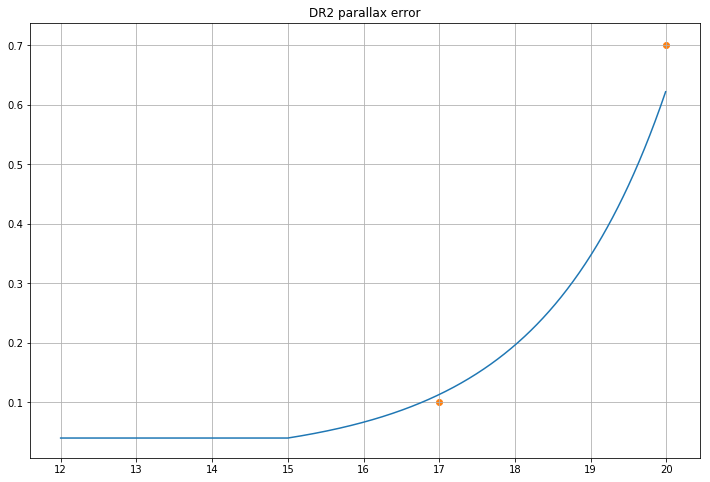

In [20]:
g = np.arange(12,20,0.01) 
plt.plot(g,parallax_error_DR2(g))
plt.scatter(17,0.1,c='C1')
plt.scatter(20,0.7,c='C1')
plt.grid()
plt.title("DR2 parallax error")